In [6]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm.notebook import trange
from loguru import logger
import re
from skimage import io
import numpy as np
from scipy import stats
import tensorflow as tf

from training.src.data_processing import tfrecords as tfr

In [2]:
root = Path.cwd().parent
data_path = root / 'training' / 'data'
tfrec = data_path / 'tfrec'

In [3]:
df = pd.read_csv(data_path / 'mo-images.csv')
df

,species,file_name,file_path,width,height,class_id
0,Daedalea quercina,607849.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,192,1995
1,Daedalea quercina,864707.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
2,Daedalea quercina,1519488.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
3,Daedalea quercina,139235.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
4,Daedalea quercina,1230024.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1995
...,...,...,...,...,...,...
402545,Chlorophyllum hortense,142019.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,179,1090
402546,Chlorophyllum hortense,795290.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1090
402547,Chlorophyllum hortense,1052100.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1090
402548,Chlorophyllum hortense,525435.jpg,/home/broug/Desktop/Mushroom-Classifier/data/M...,320,240,1090


In [4]:
def get_descriptors(path):
    im = io.imread(path)
    gray_im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    clr_im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    gray = gray_im.reshape(-1)
    im = clr_im.reshape(-1, 3)

    gray_stats = {"GRAYSTD": np.round(np.std(gray), 2), "GRAYKRT": np.round(stats.kurtosis(gray), 2), "GRAYSKEW": np.round(stats.skew(gray), 2), "GRAYIQR": int(stats.iqr(gray))}
    clr_stats = {"CLRSTD": np.round(np.std(im), 2), "CLRKRT": np.round(stats.kurtosis(im), 2), "CLRSKEW": np.round(stats.skew(im), 2), "CLRIQR": int(stats.iqr(im))}
    return {**gray_stats, **clr_stats}

def get_descriptors_df(df):
    df = df.copy()
    df = df.apply(lambda x: get_descriptors(x['file_path']), axis=1, result_type='expand')
    return df

In [5]:
def load_image(path):
    """Load and decode a jpg image from path.
    
    Returns:
        image: an image tensor
        path: the path passed as argument
    """
    im = tf.io.read_file(path)
    im = tf.io.decode_jpeg(im, channels=3)
    return im, path

def get_kurtosis(image):
    """Compute the kurtosis of an image tensor"""
    image = tf.cast(image, dtype=tf.float32)

    mean_ = tf.math.reduce_mean(image, axis=(0, 1))

    mu4 = tf.math.reduce_mean(tf.math.pow(tf.math.subtract(image, mean_), 4), axis=(0, 1))
    mu2 = tf.math.reduce_mean(tf.math.pow(tf.math.subtract(image, mean_), 2), axis=(0, 1))

    beta2 = tf.math.divide(mu4, (tf.math.pow(mu2, 2)))
    return tf.math.subtract(beta2, 3)

def get_skewness(image):
    """Compute the skewness of an image tensor"""
    _mean = tf.math.reduce_mean(image, axis=(0, 1))
    _diff = tf.cast(tf.math.subtract(image, _mean), dtype=tf.float32)

    _mu3 = tf.math.reduce_mean(tf.math.pow(_diff, 3), axis=(0, 1))
    _mu2 = tf.math.reduce_mean(tf.math.pow(_diff, 2), axis=(0, 1))

    beta = tf.math.divide(tf.math.pow(_mu3, 2), tf.math.pow(_mu2, 3))
    return tf.math.sqrt(beta)

def combined_metrics(image, path):
    """Compute the kurtosis and skewness of an image tensor, allows to combine them in a single tensor/dataset"""
    kurtosis = get_kurtosis(image)
    skewness = get_skewness(image)
    
    # Combine them, for example, in a single tensor
    return tf.stack([kurtosis, skewness], axis=-1), path

In [7]:
# load the tensor & read the image file
ds = tf.data.Dataset.from_tensor_slices(df.drop(df[df['dataset'] == 'MO'].index).loc[:, 'file_path'].astype(str))
ds = ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# apply the metrics
combined_ds = ds.map(combined_metrics, num_parallel_calls=tf.data.experimental.AUTOTUNE)
combined_ds = combined_ds.batch(4096*2).prefetch(tf.data.experimental.AUTOTUNE)

# iterate through the dataset
numpy_data = [item for item in combined_ds.as_numpy_iterator()]

In [215]:
df2

,kingdom,name,family,phylum,order,genus,class,file_name,height,width,...,skewness2_x,kurtosis3_x,skewness3_x,std,kurtosis1_y,skewness1_y,kurtosis2_y,skewness2_y,kurtosis3_y,skewness3_y
/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2021/train/05492_Fungi_Basidiomycota_Agaricomycetes_Agaricales_Amanitaceae_Amanita_gemmata/01806863-52d2-4af3-9ab2-32cf0636c771.jpg,Fungi,Amanita gemmata,Amanitaceae,Basidiomycota,Agaricales,Amanita,Agaricomycetes,01806863-52d2-4af3-9ab2-32cf0636c771.jpg,500,375,...,NaN,NaN,NaN,62.212490,0.039749,1.198414,-0.104424,1.190676,0.944192,1.172861
/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2021/train/05429_Fungi_Ascomycota_Lecanoromycetes_Peltigerales_Lobariaceae_Lobaria_anthraspis/305f0289-071d-4517-b7e4-37f36baee6da.jpg,Fungi,Lobaria anthraspis,Lobariaceae,Ascomycota,Peltigerales,Lobaria,Lecanoromycetes,305f0289-071d-4517-b7e4-37f36baee6da.jpg,500,375,...,NaN,NaN,NaN,57.815167,-0.380541,1.263538,-0.083275,1.275790,-0.157298,1.257677
/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2021/train/05664_Fungi_Basidiomycota_Agaricomycetes_Polyporales_Meripilaceae_Grifola_frondosa/2c8f6411-68ac-42d9-8e99-1ab383182019.jpg,Fungi,Grifola frondosa,Meripilaceae,Basidiomycota,Polyporales,Grifola,Agaricomycetes,2c8f6411-68ac-42d9-8e99-1ab383182019.jpg,500,500,...,NaN,NaN,NaN,36.387203,0.504171,1.267941,-0.293827,1.439638,1.891349,1.319664
/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2021/train/05493_Fungi_Basidiomycota_Agaricomycetes_Agaricales_Amanitaceae_Amanita_jacksonii/db270908-e0ea-4c76-8ffb-9a7a362dfa9c.jpg,Fungi,Amanita jacksonii,Amanitaceae,Basidiomycota,Agaricales,Amanita,Agaricomycetes,db270908-e0ea-4c76-8ffb-9a7a362dfa9c.jpg,500,375,...,NaN,NaN,NaN,52.392914,-0.476394,1.296242,-0.428082,1.350307,-0.322314,1.350262
/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2021/train/05590_Fungi_Basidiomycota_Agaricomycetes_Agaricales_Tubariaceae_Tubaria_furfuracea/1ad16b27-0711-44e3-b162-6b268a8446db.jpg,Fungi,Tubaria furfuracea,Inocybaceae,Basidiomycota,Agaricales,Tubaria,Agaricomycetes,1ad16b27-0711-44e3-b162-6b268a8446db.jpg,500,375,...,NaN,NaN,NaN,67.810323,-1.271953,1.294317,-0.886826,1.302653,-0.720825,1.309415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/broug/Desktop/Mushroom-Classifier/data/MO/images/851311.jpg,Fungi,Lactarius alnicola,Russulaceae,Basidiomycota,Russulales,Lactarius,Agaricomycetes,851311.jpg,480,640,...,1.267659,2.140747,1.228226,51.885950,2.032804,1.206564,0.782671,1.267659,2.140747,1.228226
/home/broug/Desktop/Mushroom-Classifier/data/MO/images/706755.jpg,Fungi,Phaeocalicium polyporaeum,Phaeocaliciaceae,Ascomycota,Lecanorales,Phaeocalicium,Lecanoromycetes,706755.jpg,640,480,...,1.215519,-1.352852,1.216312,76.242056,-1.386350,1.218053,-1.405637,1.215519,-1.352852,1.216312
/home/broug/Desktop/Mushroom-Classifier/data/MO/images/746551.jpg,Fungi,Psathyrella delineata,Strophariaceae,Basidiomycota,Agaricales,Psathyrella,Agaricomycetes,746551.jpg,480,640,...,1.390052,-0.364169,1.344754,45.657275,-0.602218,1.355919,-0.460865,1.390052,-0.364169,1.344754
/home/broug/Desktop/Mushroom-Classifier/data/MO/images/310483.jpg,Fungi,Suillus variegatus,Suillaceae,Basidiomycota,Boletales,Suillus,Agaricomycetes,310483.jpg,480,640,...,1.257087,2.247829,1.252519,45.111524,2.338671,1.187378,1.368189,1.257087,2.247829,1.252519


In [ ]:
# split the data into metrics and filepaths and concatenate the list they are currently in
data, fps = zip(*numpy_data)
data, fps = np.concatenate(data), np.concatenate(fps)

# reshape the data to fit in a dataframe
data = data.reshape(len(data), -1)

# convert the filepaths to strings to match with the main dataframe
fps = pd.Series(fps)
fps = fps.map(lambda x: x.decode('utf-8'))

# create a dataframe with the metrics and filepaths
ksdf = pd.DataFrame(data, columns=['kurtosis1', 'skewness1', 'kurtosis2', 'skewness2', 'kurtosis3', 'skewness3'], index=fps)
ksdf.to_csv(data_path / 'kurtosis_skewness.csv')

# merge the dataframes, joining on the index is faster which is why we set it to the filepaths
df2 = df.set_index("file_path").merge(ksdf, left_index=True, right_index=True)

# merge with original dataframe
# df = pd.concat([df, df2]).reset_index(drop=True)
df2

In [187]:
df[['height', 'width', 'class_id']] = df[['height', 'width', 'class_id']].astype(np.int16)
df['taxa'] = df['kingdom'] + '_' + df['phylum'] + '_' + df['class'] + '_' +  df['order'] + '_' +  df['family'] + '_' + df['name'].str.replace(' ', '_')
df.drop(['kingdom', 'class', 'order', 'family', 'phylum', 'genus'], axis=1, inplace=True)

In [194]:
df[['taxa', 'name']] = df[['taxa', 'name']].astype('category')
df['dataset'] = df['dataset'].astype(str)
df.to_feather(data_path / 'train_full.feather')

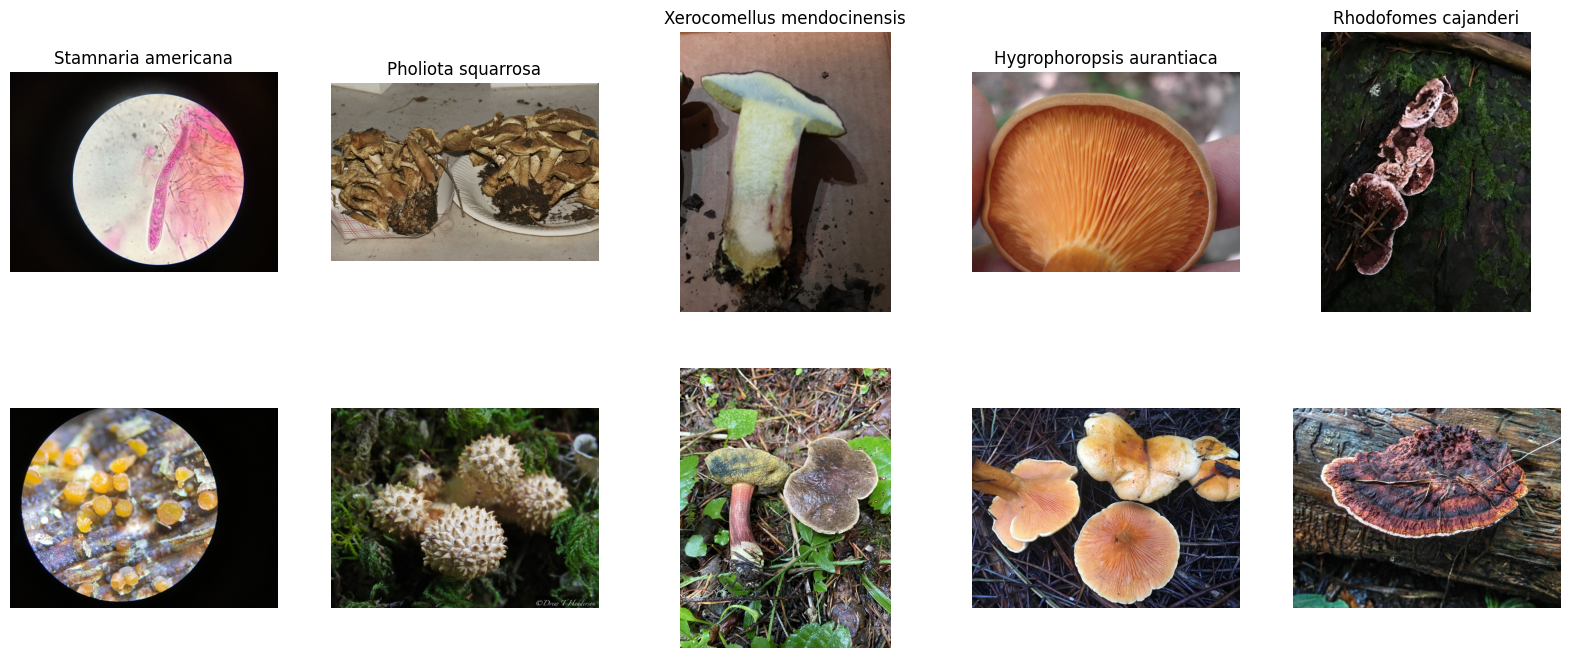

In [25]:
plt.figure(figsize=(20, 8))
classes = df['name'].sort_values().sample(5)
for i, cls in enumerate(classes, start=1):
    imgs = df[df['name'] == cls].sample(2)['file_path']
    for j, img in enumerate(imgs):
        im = cv2.imread(str(img))
        im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        plt.subplot(2, 5, i + (j * 5))
        if j == 0:
            plt.gca().set_title(cls)
        plt.axis('off')
        plt.imshow(im)

In [11]:
imgs.values

array(['/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2018/train_val2018/Fungi/5014/e42b36930a9966701963b7d81c8df443.jpg',
       '/home/broug/Desktop/Mushroom-Classifier/training/data/raw/2018/train_val2018/Fungi/5014/dd04ce9b827ee3dbbb598b41a9521af9.jpg'],
      dtype=object)

In [6]:
tests = df[df['name'] == 'Morchella esculenta'][['file_path', 'file_name']].values.tolist()
test_list = ((tests[i*25:(i+1)*25] if i <= len(tests)//25 else tests[i*25:]) for i in range(len(tests)//25 + 1))
len(tests)

7

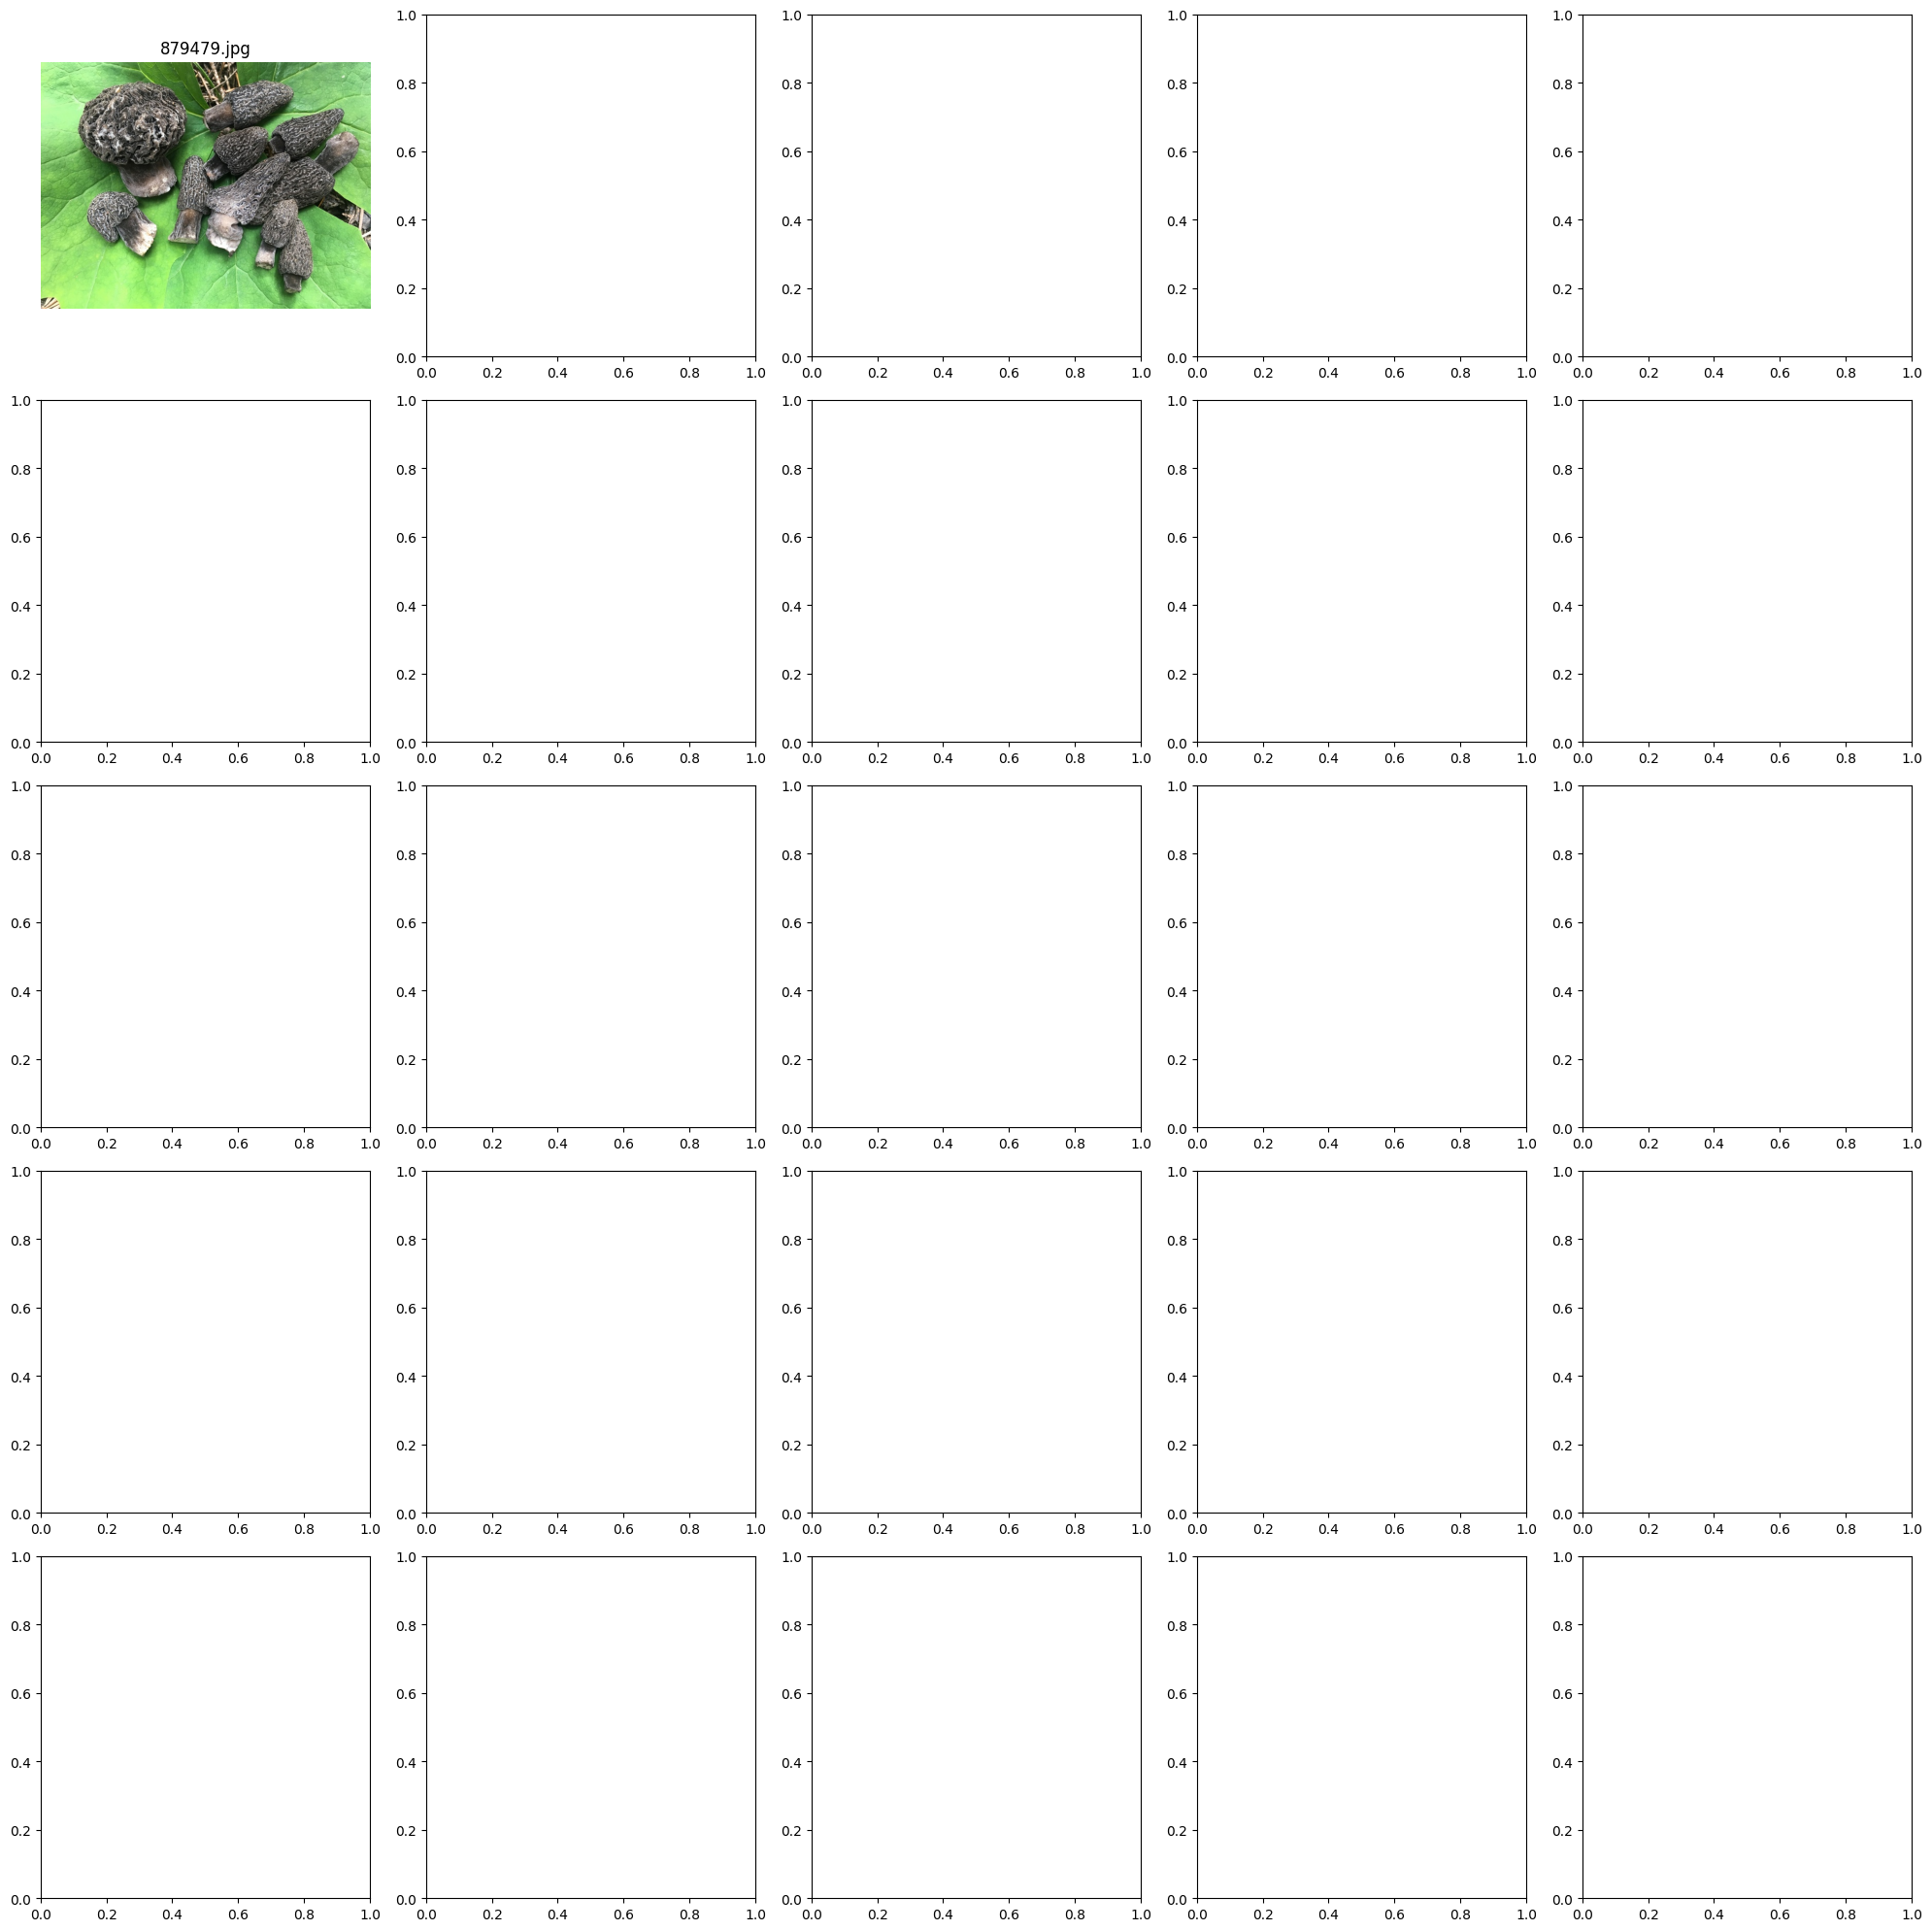

In [21]:
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

ax = axes.flatten()

for i, fp in enumerate(next(test_list)):
    fp, fn = fp
    im = cv2.imread(str(fp))
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    ax[i].imshow(im)
    ax[i].axis('off')
    ax[i].set_title(fn)
plt.tight_layout()
plt.show()

In [20]:
l2 = """
    529533:529537, 1186540:1186544, 1194817:1194827, 1194830:1194837, 1194838:1194843, 1194948:1194953, 284951:284958,
    287468:287477, 394404:394417, 385006:385008, 385109:385112, 391485:391499, 389360:389364, 405487:405490, 818050:818053, 
    1131265:1131269, 1134426:1134430, 1279831:1279833, 1280060:1280067, 1286684:1286687, 1292218:1292221, 1279538:1279541, 
    1279542:1279547, 1279548:1279563, 1282801:1282803, 1286589:1286592, 1286624:1286628, 1286614:1286617, 1286672:1286675, 1290404:1290406
"""
bad_images = [
    522595, 330821, 333048, 330131, 330130, 148191, 620123, 620668, 624434, 736409, 736410, 736416, 737349,\
    737350, 737355, 739676, 740940, 740942, 870904, 870905, 1033193, 1033204, 1035031, 1035032, 1037394, \
    1037396, 118218, 118219, 1180220, 1187414, 1177796, 1177797, 284939, 285140, 285588, 289168, \
    393143, 389461, 389462, 490028, 819324, 819329, 1273138, 1134864, 1276987, 1279318, 1279536, 1286593, \
    1286595, 1286600, 1286634, 1286606, 11286619, 1286638, 1286646, 1286649, 1286657, 1286679, 1286682, \
    1286694, 1286696, 1286702, 1286705, 1290398, 129414, 1292206, 1292213, 1292900, 1292904, 1292906,
] + l2
bad_images = [str(x) + ".jpg" for x in bad_images]
empty_img_list = [
    '1039869.jpg', '1121736.jpg', '1136990.jpg', '1181802.jpg', '773898.jpg', '773909.jpg', '773910.jpg', '773911.jpg', \
    '773912.jpg', '774071.jpg', '774103.jpg', '774109.jpg', '774110.jpg', '774128.jpg', '774129.jpg', '774131.jpg', '774135.jpg', \
    '774137.jpg', '774162.jpg', '774171.jpg', '774172.jpg', '774173.jpg', '774174.jpg'
]
list_403 = [
    '773898.jpg', '773909.jpg', '773910.jpg', '773912.jpg', '773911.jpg', '774071.jpg', '774103.jpg', '774109.jpg', '774131.jpg', \
    '774129.jpg', '774135.jpg', '774110.jpg', '774137.jpg', '774162.jpg', '774172.jpg', '774173.jpg', '774171.jpg', '774174.jpg', \
    '1121736.jpg', '1136990.jpg', '1181802.jpg', '774128.jpg', '1039869.jpg'
]
missing_list = ['1314375.jpg', '1314376.jpg', '1314377.jpg']

In [ ]:
# Regex pattern to find pairs of numbers separated by a colon
regex_pattern = r"(\d+):(\d+)"

# Find all matches and convert them into tuples of integers
tuples_list = [(int(match[0]), int(match[1])) for match in re.findall(regex_pattern, l2)]

for n in tuples_list:
    dif = range(n[1]-n[0])
    dlist = [str(n[0] + i)+".jpg" for i in dif]
    df.drop(df[df['file_name'].isin(dlist)].index, inplace=True)

df = df.drop(df[df['file_name'].isin(list_403 + missing_list + empty_img_list + bad_images)].index)

In [4]:
df = df.sample(frac=1).sample(frac=1).reset_index(drop=True)

num_train_records =  299
IMGS = df.loc[:, 'file_path'].to_list()
SIZE = len(IMGS) // num_train_records
CT = len(IMGS) // SIZE + int(len(IMGS) % SIZE != 0)

In [7]:
# iterate over the number of tfrecords
for j in trange(CT):
    # logger.info(f"Writing {j:02d} of {CT} tfrecords")
    CT2 = min(
        SIZE, len(IMGS) - j * SIZE
    )  # get the number of images in a tfrecord

    # create the path to write the tfrecord to
    path = tfrec / "tfrecords-jpeg-mo"
    path.mkdir(parents=True, exist_ok=True)

    with tf.io.TFRecordWriter(
        str(path / f"train{j:02d}-{CT2}.tfrec")
    ) as writer:

        # Iterate through the rows of the dataframe
        for k in range(CT2):  # , leave=False)
            # if k % 100 == 0:
                # logger.info(f"Writing {k:02d} of {CT2} train tfrecord images")
            row = df[df['file_path'] == IMGS[SIZE * j + k]].iloc[0]
            # load image from disk, change RGB to cv2 default BGR format, resize to reshape_sizes and encode as jpeg
            img = cv2.imread(row.file_path)
            img = cv2.imencode(".jpg", img)[1].tobytes()

            # Serialize data
            example = tfr.serialize_example(
                img,
                str(row.file_name).split(".")[0].encode('utf8'),
                row.width,
                row.height,
                row.class_id,
            )
            writer.write(example)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!gsutil -m cp -r {data}/tfrec/tfrecords-jpeg-raw/* gs://mush-img-repo/tfrecords-jpeg-raw